## Forecasted Items received by Warehouse in June each day (using lag days)

### Step 1. Importing and Reading Data

In [1]:
import pandas as pd

file_path = '/Users/kavita/Desktop/MLProject/casestudy.xlsx'  

# Load the sheets into DataFrames
historical_data = pd.read_excel(file_path, sheet_name='input_1_histrocial')
sales_forecast_data = pd.read_excel(file_path, sheet_name='input_2_sales_fc')

In [2]:
historical_data.head()

,date_order,day_of_week_order,date_wh_receive,day_of_week_wh_receive,CW,items
0,2022-01-01,6,2022-01-01,6,52,18338
1,2022-01-01,6,2022-01-02,7,52,408
2,2022-01-01,6,2022-01-03,1,1,2551
3,2022-01-01,6,2022-01-04,2,1,11965
4,2022-01-01,6,2022-01-05,3,1,180


In [3]:
sales_forecast_data.head()

,date_order,day_of_week_order,Forecated_items
0,2022-06-01,3,80882
1,2022-06-02,4,58562
2,2022-06-03,5,55809
3,2022-06-04,6,48880
4,2022-06-05,7,49208


### Step 2. Lag days calculation


As there is time lag between order_date and date_wh_receive, we are calculating this lag by subtracting date_order from date_wh_receive.

In [4]:
# Calculate the lag in days between order and warehouse receipt
historical_data['lag_days'] = (historical_data['date_wh_receive'] - historical_data['date_order']).dt.days


### Step 3.a. Calculating item distribution percentage with lag days

In [5]:
# Filter out records where lag days exceed 15, as after that item count is 0 in most cases
filtered_data = historical_data[historical_data['lag_days'] <= 15]

# Group by lag days and sum up items for each lag day
lag_days_with_items_distribution = filtered_data.groupby('lag_days')['items'].sum()

# Calculate the total items received across all considered lag days
total_items = lag_days_with_items_distribution.sum()

# Calculate the percentage of total items received for each lag day
distribution_percentages = (lag_days_with_items_distribution / total_items * 100).reset_index()

# distribution_percentages['items'] = distribution_percentages['items'].round(2)

distribution_percentages.columns = ['receipt_diff', 'items']

# reading this percentage
distribution_percentages.head(15)
# print(distribution_percentages)

,receipt_diff,items
0,0,46.260503
1,1,19.697324
2,2,26.348282
3,3,5.530210
4,4,1.339622
5,5,0.419862
6,6,0.116869
7,7,0.126492
8,8,0.076021
9,9,0.036910


In [6]:
print(lag_days_with_items_distribution)

lag_days
0     4792732
1     2040704
2     2729764
3      572947
4      138789
5       43499
6       12108
7       13105
8        7876
9        3824
10       2264
11       1472
12        724
13        410
14         81
15         12
Name: items, dtype: int64


In [7]:
print(total_items)

10360311


### 3.b. Plotting graph for distribution

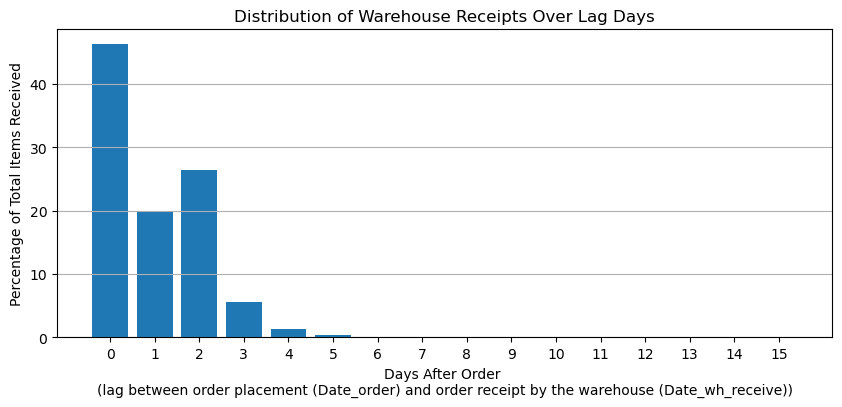

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(distribution_percentages['receipt_diff'], distribution_percentages['items'])
plt.title('Distribution of Warehouse Receipts Over Lag Days')
plt.xlabel('Days After Order \n(lag between order placement (Date_order) and order receipt by the warehouse (Date_wh_receive))')
plt.ylabel('Percentage of Total Items Received')

xtick_labels = distribution_percentages['receipt_diff']

plt.xticks(distribution_percentages['receipt_diff'], labels=xtick_labels)
plt.grid(axis='y')

plt.show()


### Step 4. Calculating forecasted items received by Warehouse in June 2022

#### 4.a. Adjusting the sales forecast according to the distribution observed

In [9]:
# This line creates a date range that spans from the earliest date_order in sales forecast data to the latest date_order plus an additional 15 days. 
# This extended range accounts for the lag between order dates and when items are actually received, ensuring a timeline that can accommodate 
# the distribution of received items beyond just the order dates.
forecast_dates = pd.date_range(start=sales_forecast_data['date_order'].min(), 
                               end=sales_forecast_data['date_order'].max() 
                               + pd.Timedelta(days=15))

#### 4.b. DataFrame initialization

In [10]:
# Here, initializing a DataFrame named forecast_distribution with the previously defined forecast_dates as 
# its index. This DataFrame will track the total expected items to be received by the warehouse each day. 
# Initially, all values in the total_expected_items column are set to 0, preparing the DataFrame to accumulate forecasted values.
forecast_distribution = pd.DataFrame(index=forecast_dates, columns=['forecasted_wh_received_items'])
forecast_distribution['forecasted_wh_received_items'] = 0  # Initialize all values to 0


#### 4.c. Applying the historical distribution to each day's forecasted sales

In [11]:
# Adjusting the sales forecast according to the distribution observed
# This line creates a date range that spans from the earliest date_order in sales forecast data to the latest date_order plus an additional 15 days. 
# This extended range accounts for the lag between order dates and when items are actually received, ensuring a timeline that can accommodate 
# the distribution of received items beyond just the order dates.
forecast_dates = pd.date_range(start=sales_forecast_data['date_order'].min(), 
                               end=sales_forecast_data['date_order'].max() 
                               + pd.Timedelta(days=15))


# Here, I initialize a DataFrame named forecast_distribution with the previously defined forecast_dates as 
# its index. This DataFrame will track the total expected items to be received by the warehouse each day. 
# Initially, all values in the total_expected_items column are set to 0, preparing the DataFrame to accumulate forecasted values.
forecast_distribution = pd.DataFrame(index=forecast_dates, columns=['forecasted_wh_received_items'])
forecast_distribution['forecasted_wh_received_items'] = 0  # Initialize all values to 0

# Applying the historical distribution to each day's forecasted sales
for _, row in sales_forecast_data.iterrows():
    for _, dist in distribution_percentages.iterrows():
        forecast_date = row['date_order'] + pd.Timedelta(days=int(dist['receipt_diff']))
        if forecast_date in forecast_distribution.index:
            forecast_distribution.at[forecast_date, 'forecasted_wh_received_items'] += row['Forecated_items'] * (dist['items'] / 100)

# Finally, the reset_index call moves the index (which contains dates) into a regular column, 
# making it easier to work with or export. This column is then renamed to date_wh_receive to clearly 
# indicate these are the dates when the warehouse is expected to receive items.
            
forecast_distribution.reset_index(inplace=True)
forecast_distribution.rename(columns={'index': 'date_wh_receive'}, inplace=True)


In [12]:
# Display the forecast_distribution DataFrame
display(forecast_distribution.round())

,date_wh_receive,forecasted_wh_received_items
0,2022-06-01,37416.0
1,2022-06-02,43023.0
2,2022-06-03,58664.0
3,2022-06-04,53508.0
4,2022-06-05,51419.0
5,2022-06-06,70755.0
6,2022-06-07,74830.0
7,2022-06-08,99698.0
8,2022-06-09,81409.0
9,2022-06-10,79375.0


In [13]:
# total sum of forecasted_wh_received_items
forecast_distribution['forecasted_wh_received_items'].sum()

2433610.0

In [14]:
# Validating if sum of order items and sum of warehouse received items equal.
sales_forecast_data['Forecated_items'].sum() == forecast_distribution['forecasted_wh_received_items'].sum()

True

In [15]:
# Save the forecast to a csv file
forecast_distribution.to_csv("forecast_distribution_june_2024.csv", index=False)
from IPython.display import FileLink
FileLink('forecast_distribution_june_2024.csv') 

/Users/kavita/forecast_distribution_june_2024.csv

## Calculate the accuracy of your model with preferred accuracy/error metric

To evaluate the model's accuracy, I would typically compare the forecasted values against actual received items using several metrics. For example:


1. Mean Absolute Error (MAE): the average of the absolute differences between forecasted and actual values
2. Mean Absolute Percentage Error (MAPE): it expresses accuracy as a percentage of the error, making it easy to interpret and particularly useful for comparing the accuracy of forecasting methods across different datasets or scales.
